<a href="https://colab.research.google.com/github/vokashlob/OTUS/blob/main/OTUS_torch_practice_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch

In [41]:
data = 20*torch.rand(20000,3)-10
x = data[:,0]
y = data[:,1]
data[:,2] = torch.sin(x + 2*y)*torch.exp(-(2*x + y)**2)
data.shape

torch.Size([20000, 3])

In [56]:
print(data[:,2].min(), data[:,2].max())

tensor(-0.9965) tensor(0.9974)


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [64]:
z = data[:,2]

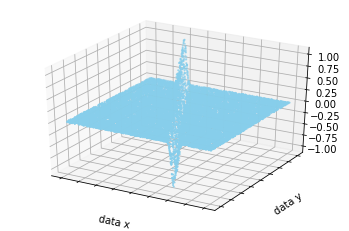

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='skyblue', s=1)
plt.xlabel('data x')
plt.ylabel('data y')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()